In [790]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

In [791]:
LMT_DATA = yf.download('LMT', start='2014-01-01', end='2023-12-31')
LMT_DATA.fillna(method='bfill', inplace=True)
LMT_DATA

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,147.050003,147.789993,145.839996,146.070007,110.232216,1115900
2014-01-03,146.500000,147.330002,146.479996,147.059998,110.979286,843400
2014-01-06,147.300003,148.089996,146.100006,146.279999,110.390625,1134800
2014-01-07,149.000000,149.300003,147.500000,148.610001,112.148987,1684100
2014-01-08,148.389999,149.100006,147.710007,148.500000,112.065941,1222700
...,...,...,...,...,...,...
2023-12-22,450.000000,451.739990,448.109985,448.220001,444.955353,623600
2023-12-26,448.149994,451.440002,447.820007,450.179993,446.901062,516900
2023-12-27,448.549988,451.019989,448.410004,448.970001,445.699890,699900


In [792]:
LMT_DATA['Open-Close'] = LMT_DATA.Open - LMT_DATA.Close
LMT_DATA['High-Low'] = LMT_DATA.High - LMT_DATA.Low
LMT_DATA['Price-Volume'] = LMT_DATA['Volume'] * LMT_DATA['Close']
LMT_DATA['Return'] = LMT_DATA['Close'].pct_change().shift(-1)
LMT_DATA['SMA-5'] = LMT_DATA['Close'].rolling(window = 5).mean()
LMT_DATA['SMA-10'] = LMT_DATA['Close'].rolling(window = 10).mean()
LMT_DATA['SMA-20'] = LMT_DATA['Close'].rolling(window = 20).mean()
LMT_DATA['EMA-15'] = LMT_DATA['Close'].ewm(span=12, adjust=False).mean()
LMT_DATA['EMA-30'] = LMT_DATA['Close'].ewm(span=26, adjust=False).mean()
LMT_DATA['MACD'] = LMT_DATA['EMA-15'] - LMT_DATA['EMA-30']
LMT_DATA['MACD-Signal'] = LMT_DATA['MACD'].ewm(span=9, adjust=False).mean()

def rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

LMT_DATA['RSI'] = rsi(LMT_DATA['Close'], 14)
LMT_DATA['Next-Price'] = np.where(LMT_DATA['Close'].shift(-1)>LMT_DATA['Close'], 1, 0)
LMT_DATA.dropna(inplace=True)
LMT_DATA

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Price-Volume,Return,SMA-5,SMA-10,SMA-20,EMA-15,EMA-30,MACD,MACD-Signal,RSI,Next-Price
Date,,,,,,,,,,,,,,,,,,,
2014-01-30,148.589996,150.289993,147.669998,148.660004,112.186729,1931600,-0.070007,2.619995,2.871517e+08,0.015135,147.814001,150.762003,149.908001,149.555773,149.147663,0.408110,1.016034,49.833906,1
2014-01-31,147.070007,151.990005,145.940002,150.910004,113.884697,2618200,-3.839996,6.050003,3.951126e+08,-0.021006,148.444003,150.504002,150.150001,149.764116,149.278207,0.485909,0.910009,53.230109,0
2014-02-03,150.539993,152.000000,147.419998,147.740005,111.492455,2307200,2.799988,4.580002,3.408657e+08,0.002978,148.588004,149.896002,150.184001,149.452714,149.164266,0.288448,0.785697,43.456794,1
2014-02-04,147.789993,148.970001,144.690002,148.179993,111.824509,2205000,-0.389999,4.279999,3.267369e+08,0.014914,148.568002,149.304001,150.279001,149.256911,149.091357,0.165554,0.661669,43.316805,1
2014-02-05,147.740005,151.970001,147.429993,150.389999,113.492302,2728100,-2.649994,4.540009,4.102790e+08,0.008977,149.176001,148.678001,150.368001,149.431232,149.187553,0.243680,0.578071,43.619189,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,444.239990,448.100006,444.220001,448.019989,444.756805,637200,-3.779999,3.880005,2.854783e+08,0.000446,445.426001,447.475000,447.807999,446.970035,446.748085,0.221950,0.804686,48.350329,1
2023-12-22,450.000000,451.739990,448.109985,448.220001,444.955353,623600,1.779999,3.630005,2.795100e+08,0.004373,446.708002,447.495001,447.618498,447.162338,446.857116,0.305222,0.704793,46.991478,1
2023-12-26,448.149994,451.440002,447.820007,450.179993,446.901062,516900,-2.029999,3.619995,2.326980e+08,-0.002688,447.362000,447.387000,447.852998,447.626592,447.103255,0.523337,0.668502,55.108917,0


### Exploratory Data Analysis (EDA)


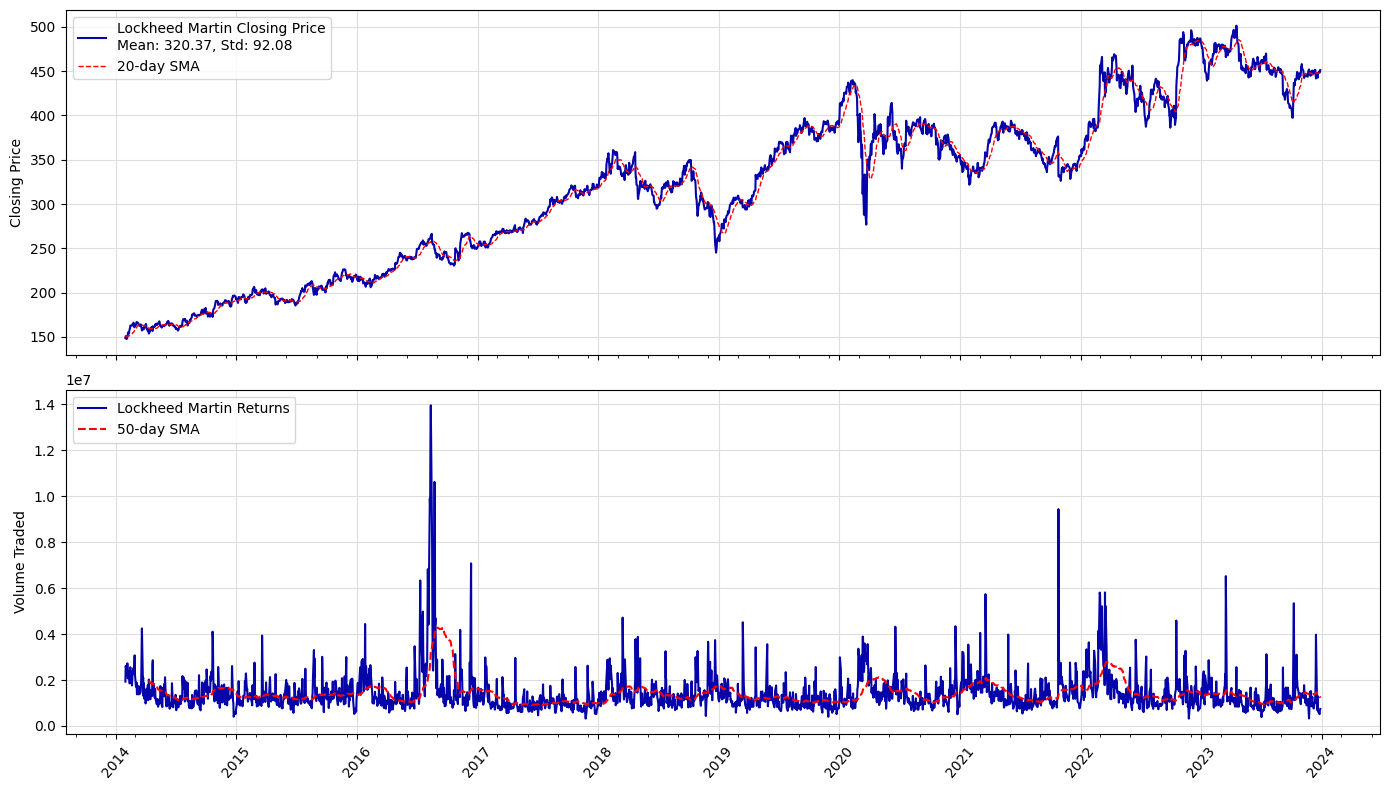

In [793]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

close_mean = LMT_DATA['Close'].mean()
close_std = LMT_DATA['Close'].std()

return_mean = LMT_DATA['Return'].mean()
return_std = LMT_DATA['Return'].std()

# Top chart: Closing Prices
ax1.plot(LMT_DATA.index, LMT_DATA['Close'], label=f'Lockheed Martin Closing Price\nMean: {close_mean:.2f}, Std: {close_std:.2f}', color='#0504aa')
ax1.plot(LMT_DATA.index, LMT_DATA['SMA-20'], label='20-day SMA', color='red', linestyle='--', linewidth=1)
ax1.set_ylabel('Closing Price')
ax1.legend(loc='upper left')
ax1.grid(True, color="#dedede")


# Bottom chart: Returns
ax2.plot(LMT_DATA.index, LMT_DATA['Volume'], label='Lockheed Martin Returns', color='#0504aa')
ax2.set_ylabel('Volume Traded')
ax2.legend(loc='upper left')
ax2.grid(True, color="#dedede")  # Set grid on both major and minor tick marks

# Apply a 50-day simple moving average on the Returns
ax2.plot(LMT_DATA.index, LMT_DATA['Volume'].rolling(window=50).mean(), label='50-day SMA', color='red', linestyle='--')
ax2.legend(loc='upper left')

# Formatting the x-axis to show only the years
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_tick_params(rotation=50, which='both')

# Adjusting the layout
plt.tight_layout()

# Show plot
plt.show()

Text(0.5, 1.0, 'Distribution of Returns')

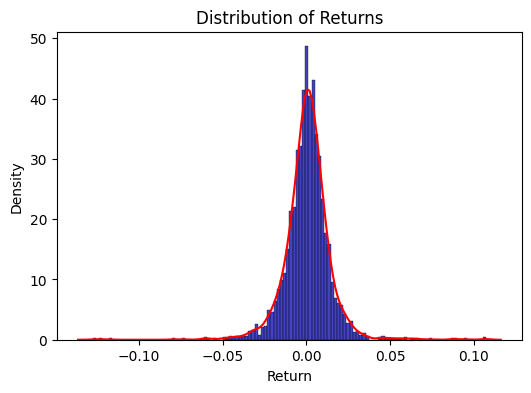

In [794]:
plt.figure(figsize=(6, 4))
sns.histplot(data=LMT_DATA, x="Return", kde=False, stat="density", color='#0504aa')
sns.kdeplot(data=LMT_DATA, x="Return", color='red', linewidth=1.5)
plt.title('Distribution of Returns')

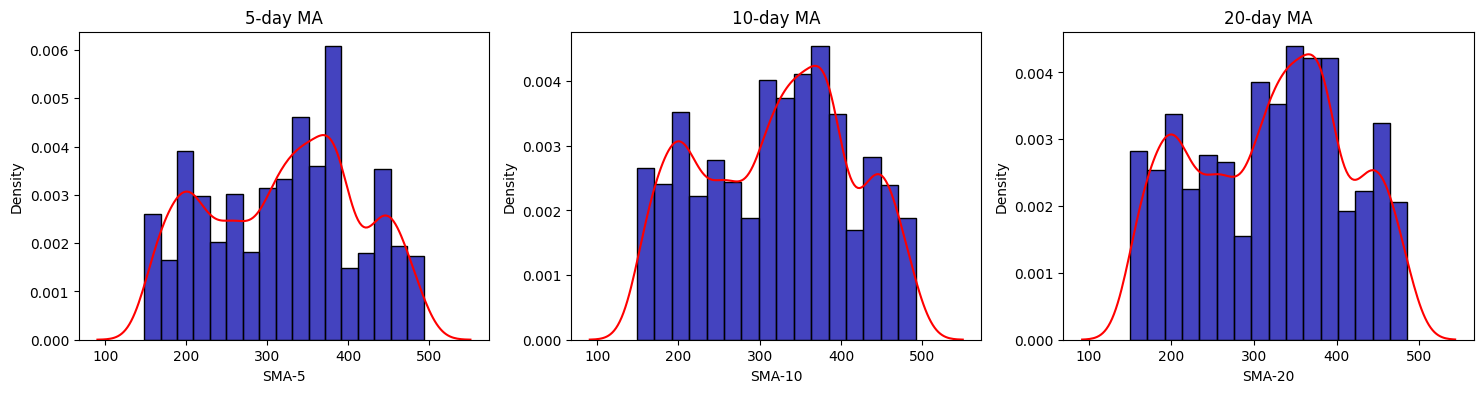

In [795]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns

# Histogram for SMA-5 with a separate KDE plot
sns.histplot(data=LMT_DATA, x="SMA-5", kde=False, stat="density", ax=axes[0], color='#0504aa')
sns.kdeplot(data=LMT_DATA, x="SMA-5", ax=axes[0], color='red', linewidth=1.5)
axes[0].set_title('5-day MA')

# Histogram for SMA-10 with a separate KDE plot
sns.histplot(data=LMT_DATA, x="SMA-10", kde=False, stat="density", ax=axes[1], color='#0504aa')
sns.kdeplot(data=LMT_DATA, x="SMA-10", ax=axes[1], color='red', linewidth=1.5)
axes[1].set_title('10-day MA')

# Histogram for SMA-20 with a separate KDE plot
sns.histplot(data=LMT_DATA, x="SMA-20", kde=False, stat="density", ax=axes[2], color='#0504aa')
sns.kdeplot(data=LMT_DATA, x="SMA-20", ax=axes[2], color='red', linewidth=1.5)
axes[2].set_title('20-day MA')

plt.show()

Text(0.5, 1.0, 'Price vs Volume')

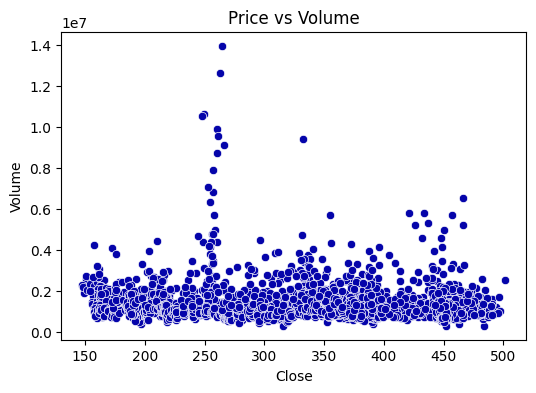

In [796]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=LMT_DATA, x='Close', y='Volume', color="#0504aa")
plt.title('Price vs Volume')

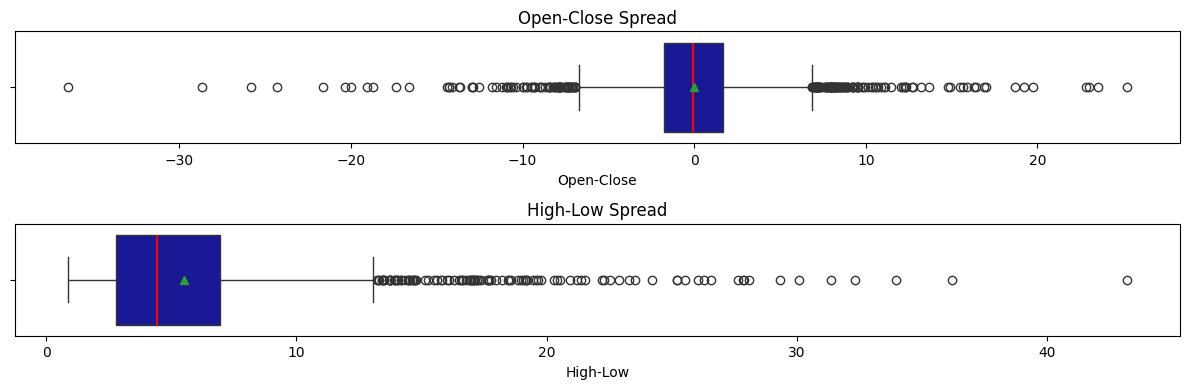

In [797]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4))  # 2 rows, 1 column

# Boxplot for 'Open-Close' horizontally with blue color and a red mean line.
sns.boxplot(data=LMT_DATA, x='Open-Close', ax=axes[0], orient='h', color='#0504aa',
            showmeans=True,
            medianprops={"color": "red", "ls": "-", "lw": 1.5})

axes[0].set_title('Open-Close Spread')

# Boxplot for 'High-Low' horizontally with blue color and a red mean line.
sns.boxplot(data=LMT_DATA, x='High-Low', ax=axes[1], orient='h', color='#0504aa',
            showmeans=True,
            medianprops={"color": "red", "ls": "-", "lw": 1.5})

axes[1].set_title('High-Low Spread')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Histogram')

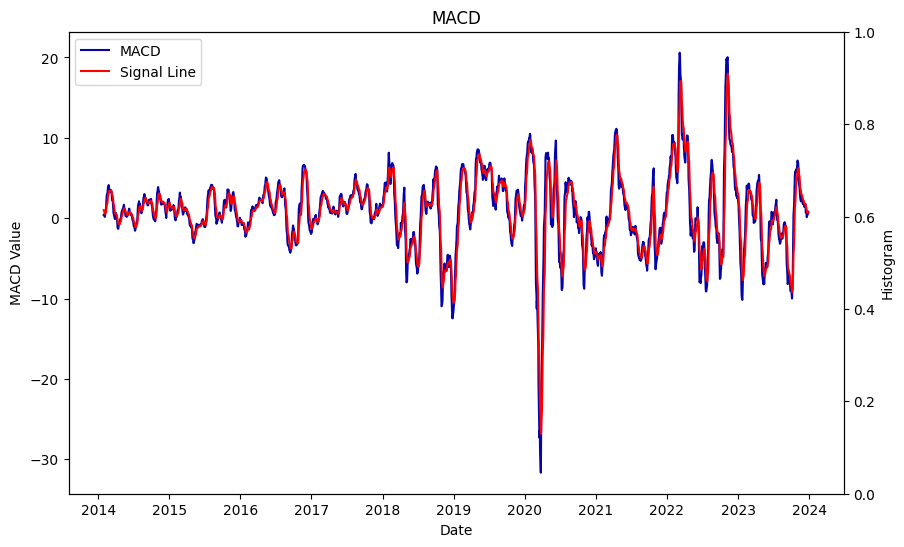

In [798]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_title('MACD')

# Plot the MACD and Signal lines
sns.lineplot(data=LMT_DATA, x=LMT_DATA.index, y='MACD', ax=ax1, label='MACD', color='#0504aa')
sns.lineplot(data=LMT_DATA, x=LMT_DATA.index, y='MACD-Signal', ax=ax1, label='Signal Line', color='red')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Set labels for both y-axes
ax1.set_ylabel('MACD Value')
ax2.set_ylabel('Histogram')

In [799]:
# Let's consider only the features we are interested in:
MODEL_DATA = LMT_DATA[['Open-Close', 'High-Low', 'Price-Volume', 'SMA-5', 'SMA-10', 'SMA-20', 'RSI', 'MACD', 'MACD-Signal', 'Next-Price']]

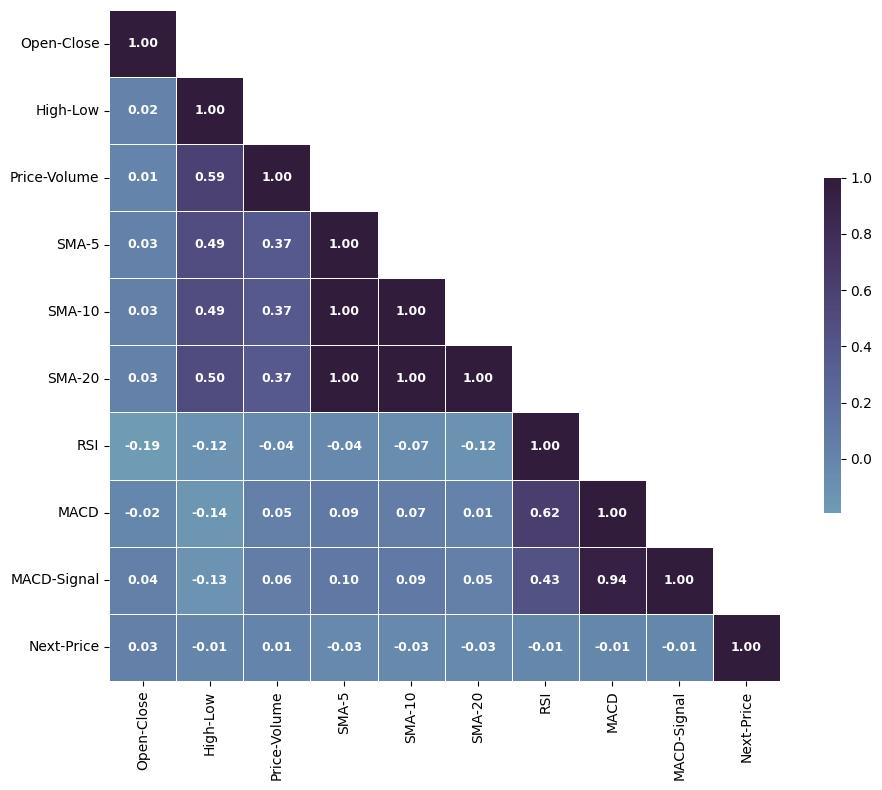

In [800]:
corr_matrix = MODEL_DATA.corr()

# Create a mask to hide the upper triangle of the correlation matrix, including the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Modify the mask to keep the diagonal
mask[np.diag_indices_from(mask)] = False

# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_blue_red', ["#bb0a28", "white", "#3a3c98"], N=900000)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and custom colormap
sns.heatmap(corr_matrix, cmap=sns.cubehelix_palette(start=.5, rot=-0.5, as_cmap=True), mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
            annot_kws={"size": 9, "weight": "bold"})

# Adjust the plot as needed
plt.tight_layout()
plt.show()

### Train and Test preprocessing

In [801]:
# spilting the data into dependent and independent variables
X = MODEL_DATA.iloc[:, :-1]
Y = MODEL_DATA.iloc[:, -1]

In [802]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=False)
X_TRAIN.shape, X_TEST.shape


((1996, 9), (500, 9))

In [803]:
X_TRAIN

,Open-Close,High-Low,Price-Volume,SMA-5,SMA-10,SMA-20,RSI,MACD,MACD-Signal
Date,,,,,,,,,
2014-01-30,-0.070007,2.619995,2.871517e+08,147.814001,150.762003,149.908001,49.833906,0.408110,1.016034
2014-01-31,-3.839996,6.050003,3.951126e+08,148.444003,150.504002,150.150001,53.230109,0.485909,0.910009
2014-02-03,2.799988,4.580002,3.408657e+08,148.588004,149.896002,150.184001,43.456794,0.288448,0.785697
2014-02-04,-0.389999,4.279999,3.267369e+08,148.568002,149.304001,150.279001,43.316805,0.165554,0.661669
2014-02-05,-2.649994,4.540009,4.102790e+08,149.176001,148.678001,150.368001,43.619189,0.243680,0.578071
...,...,...,...,...,...,...,...,...,...
2021-12-27,-3.179993,3.809998,3.383355e+08,343.726001,344.322003,340.961003,67.683399,1.140205,0.246443
2021-12-28,-3.690002,5.660004,2.927281e+08,346.991998,345.142004,341.587003,72.881367,1.843349,0.565824
2021-12-29,-0.829987,2.809998,2.733902e+08,349.691998,346.005002,342.634502,71.644265,2.414719,0.935603


In [804]:
#Standardisation of the features
sc = StandardScaler()
X_TRAIN = sc.fit_transform(X_TRAIN)
X_TEST = sc.transform(X_TEST)
X_TRAIN

array([[-0.02603394, -0.58707316, -0.44363737, ..., -0.23576828,
        -0.0640007 ,  0.08469697],
       [-1.04247499,  0.32169187, -0.04482236, ..., -0.03218642,
        -0.04583605,  0.0578777 ],
       [ 0.74775634, -0.06777828, -0.24521388, ..., -0.61803758,
        -0.09193925,  0.02643266],
       ...,
       [-0.23093483, -0.53673288, -0.49447334, ...,  1.07163089,
         0.404503  ,  0.06435167],
       [ 0.37569622, -0.13667073, -0.48755853, ...,  0.81860227,
         0.48974509,  0.15765099],
       [-0.61109127,  0.17597106, -0.3395825 , ...,  0.85539801,
         0.58321829,  0.25254418]])

### Support Vector Classifier

In [805]:
# Create an instance of SVC
SVC_MODEL = SVC(C=0.1, kernel='rbf', gamma=0.1, random_state=101)
SVC_MODEL.fit(X_TRAIN, Y_TRAIN)
SVC_PREDICTIONS = SVC_MODEL.predict(X_TEST)
print(classification_report(Y_TEST, SVC_PREDICTIONS))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       243
           1       0.51      1.00      0.68       257

    accuracy                           0.51       500
   macro avg       0.26      0.50      0.34       500
weighted avg       0.26      0.51      0.35       500



In [806]:
svc_accuracy = cross_val_score(SVC_MODEL, X, Y, cv=5, scoring='accuracy')
print('SVC Model Accuracy:', round(svc_accuracy.mean(), 4) * 100, '%')
print('SVC Model Standard Deviation:', round(svc_accuracy.std(), 5))

SVC Model Accuracy: 53.690000000000005 %
SVC Model Standard Deviation: 0.00043


### Naive Bayesian Classifier

In [807]:
NBC_MODEL = GaussianNB()
NBC_MODEL.fit(X_TRAIN, Y_TRAIN)
NBC_PREDICTIONS = NBC_MODEL.predict(X_TEST)
print(classification_report(Y_TEST, NBC_PREDICTIONS))

              precision    recall  f1-score   support

           0       0.50      0.87      0.63       243
           1       0.59      0.17      0.27       257

    accuracy                           0.51       500
   macro avg       0.54      0.52      0.45       500
weighted avg       0.54      0.51      0.44       500



In [808]:
nbc_accuracy = cross_val_score(NBC_MODEL, X, Y, cv=5, scoring='accuracy')
print('NBC Model Accuracy:', round(nbc_accuracy.mean(), 4) * 100, '%')
print('NBC Model Standard Deviation:', round(nbc_accuracy.std(), 5))

NBC Model Accuracy: 52.800000000000004 %
NBC Model Standard Deviation: 0.01753


Naive Bayesian Model seems to work the best

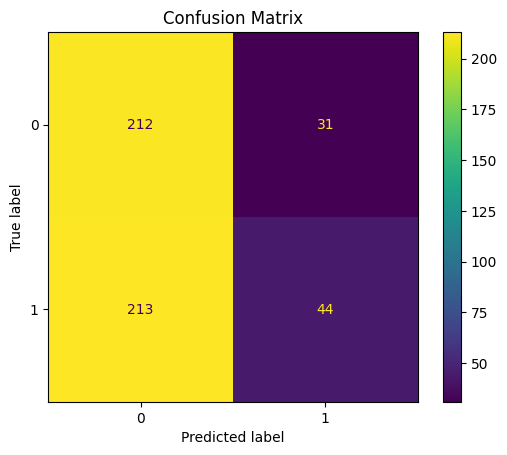

In [809]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_TEST, NBC_PREDICTIONS)

# Evaluate the modelet by means of a Confusion Matrix
matrix = ConfusionMatrixDisplay.from_estimator(NBC_MODEL, X_TEST, Y_TEST)  
plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()


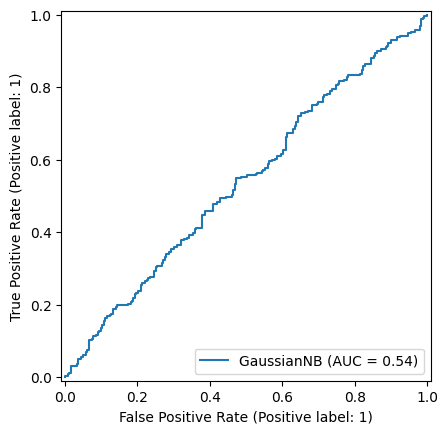

In [810]:
roc_curve = RocCurveDisplay.from_estimator(NBC_MODEL, X_TEST, Y_TEST)

### Market and Strategy Returns

In [811]:
# Create new column with predicted values
LMT_DATA['Predicted-Price'] = np.NaN
LMT_DATA.iloc[len(LMT_DATA)-len(NBC_PREDICTIONS):, -1] = NBC_PREDICTIONS
TRADE_DATA = LMT_DATA[['Close', 'Next-Price', 'Predicted-Price']].dropna()
TRADE_DATA

,Close,Next-Price,Predicted-Price
Date,,,
2022-01-03,354.359985,1,1.0
2022-01-04,361.989990,0,0.0
2022-01-05,358.140015,0,1.0
2022-01-06,358.000000,1,1.0
2022-01-07,360.140015,1,1.0
...,...,...,...
2023-12-21,448.019989,1,0.0
2023-12-22,448.220001,1,0.0
2023-12-26,450.179993,0,0.0


In [812]:
TRADE_DATA['Tomorrows-Returns'] = np.log(TRADE_DATA['Close']/TRADE_DATA['Close'].shift(1))
TRADE_DATA['Tomorrows-Returns'] = TRADE_DATA['Tomorrows-Returns'].shift(-1)
TRADE_DATA

,Close,Next-Price,Predicted-Price,Tomorrows-Returns
Date,,,,
2022-01-03,354.359985,1,1.0,0.021303
2022-01-04,361.989990,0,0.0,-0.010693
2022-01-05,358.140015,0,1.0,-0.000391
2022-01-06,358.000000,1,1.0,0.005960
2022-01-07,360.140015,1,1.0,0.008598
...,...,...,...,...
2023-12-21,448.019989,1,0.0,0.000446
2023-12-22,448.220001,1,0.0,0.004363
2023-12-26,450.179993,0,0.0,-0.002691


In [813]:
TRADE_DATA['Strategy-Returns'] = np.where(TRADE_DATA['Predicted-Price'] == 1, 
                                          TRADE_DATA['Tomorrows-Returns'], 
                                          - TRADE_DATA['Tomorrows-Returns'])
TRADE_DATA

,Close,Next-Price,Predicted-Price,Tomorrows-Returns,Strategy-Returns
Date,,,,,
2022-01-03,354.359985,1,1.0,0.021303,0.021303
2022-01-04,361.989990,0,0.0,-0.010693,0.010693
2022-01-05,358.140015,0,1.0,-0.000391,-0.000391
2022-01-06,358.000000,1,1.0,0.005960,0.005960
2022-01-07,360.140015,1,1.0,0.008598,0.008598
...,...,...,...,...,...
2023-12-21,448.019989,1,0.0,0.000446,-0.000446
2023-12-22,448.220001,1,0.0,0.004363,-0.004363
2023-12-26,450.179993,0,0.0,-0.002691,0.002691


In [814]:
TRADE_DATA['Cumulative-Market-Returns'] = TRADE_DATA['Tomorrows-Returns'].cumsum()
TRADE_DATA['Cumulative-Strategy-Returns'] = TRADE_DATA['Strategy-Returns'].cumsum()

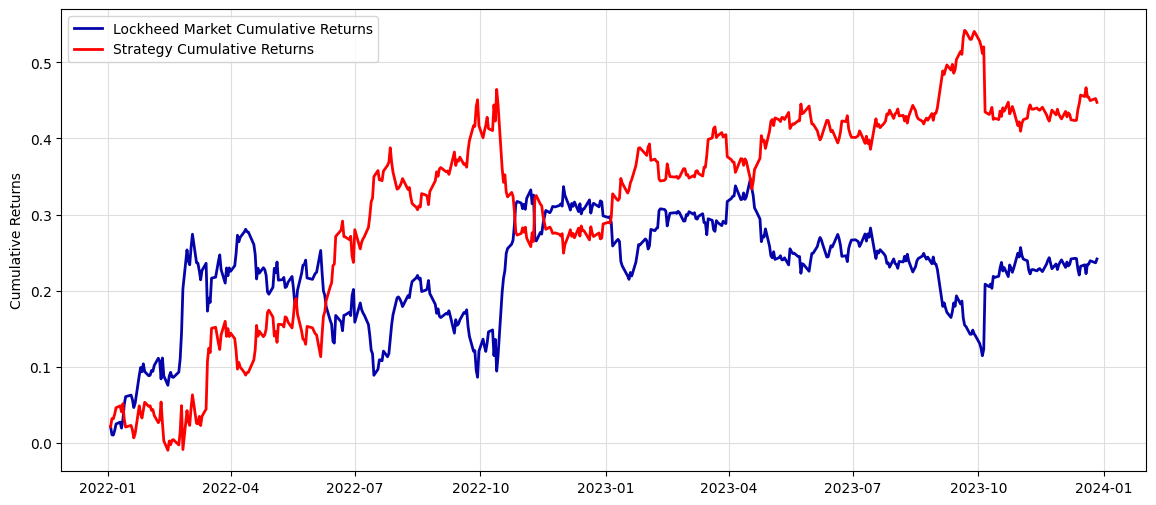

In [815]:
plt.figure(figsize=(14, 6))
plt.plot(TRADE_DATA['Cumulative-Market-Returns'], label=f'Lockheed Market Cumulative Returns', color='#0504aa', linewidth=2)
plt.plot(TRADE_DATA['Cumulative-Strategy-Returns'], label='Strategy Cumulative Returns', color='red', linewidth=2)
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True, color="#dedede")